# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels['real_age'].value_counts().head(15)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: real_age, dtype: int64

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


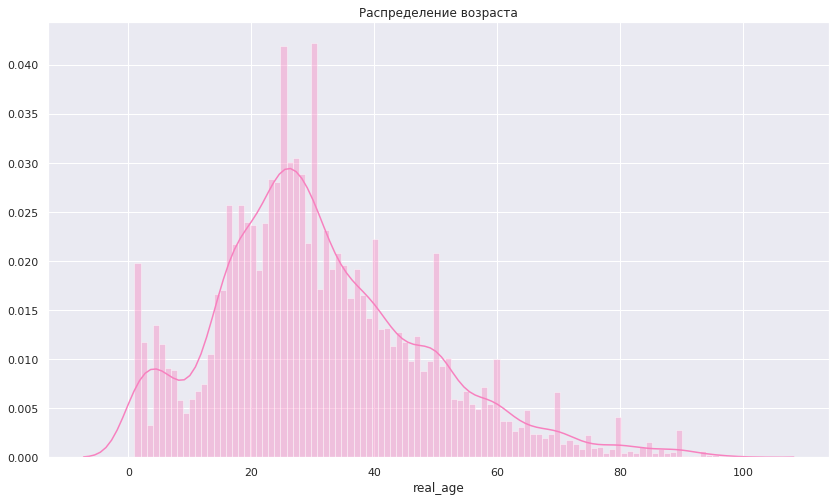

In [5]:
plt.figure(figsize=(14,8))
sns.set(style = 'darkgrid', palette = 'Set1_r')
sns.distplot(labels["real_age"], hist = True, bins=100)
plt.title('Распределение возраста')
display(labels.describe())

In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


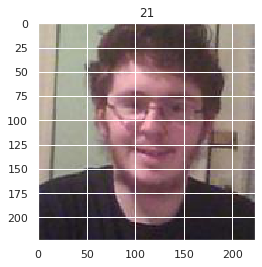

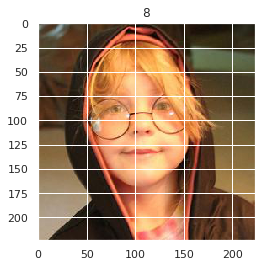

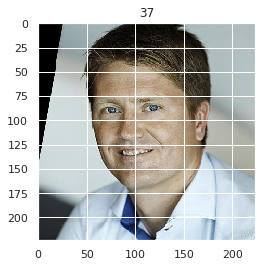

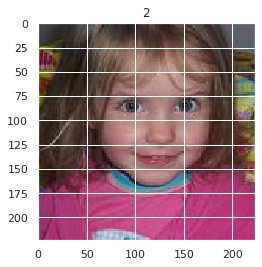

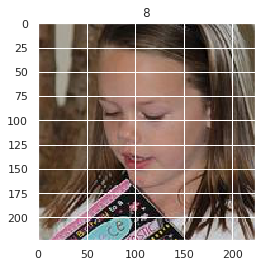

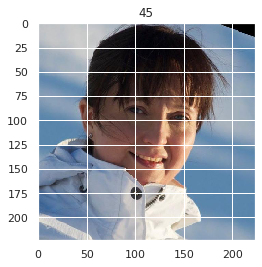

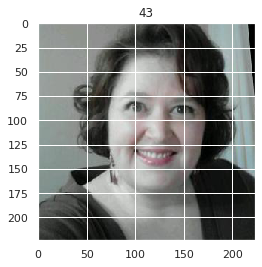

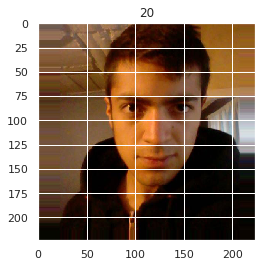

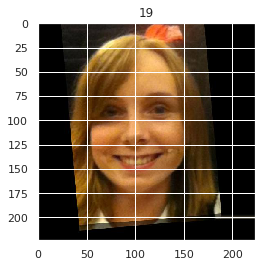

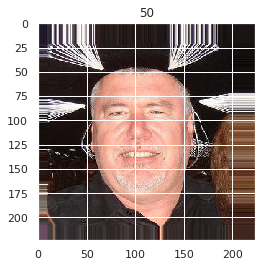

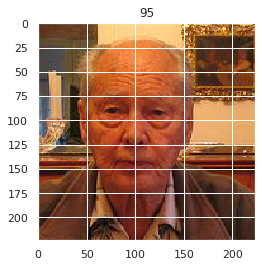

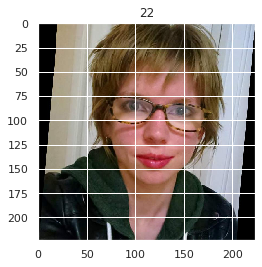

In [11]:
features, target = next(train_gen_flow)

#fig = plt.figure(figsize=(10,10))
for age, photo in zip(target[:12], features[:12]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

Выводы по шагу 1:
- 7591 фотографий/наблюдений в нашей выборке и основное количество приходится на возраст от 20-30
- на некоторых фотографиях присутствуют объекты, которые закрывают лицо
- некоторые фотографии повернуты
- есть цветные фотографии, есть ч/б

В целом, для модели будет продуктивнее наличие самых разных фотографий: пиксельных, с шумами, плохим освещением и т.д. Это может повысить качество работы модели в дальнейшем: у нее будет меньше проблем с определением "проблемных" фотографий. 

<div style="border: 1px solid #483D8B; border-radius: 3px;">
<table> <tr> <td bgcolor = #E6E6FA>
    
    
<span style="color:#483D8B"> <font face = "Courier New" size=4> 
    **Выборка** содержит 7591 изображение, максимальное количество изображений для одной категории: 317. Есть некоторый объем категорий, для которых в датасете всего по 1 фотографии. Не слишком много: использую ResNet50, добавив сверху полносвязный слой с Relu активацией.  
    **Гистограмма** содержит информацию о фотографиях людей в диапазоне от 1 года до 100 лет. Основная часть фотографий - люди  20-30 лет, есть пики: 25 и 30 лет. Годовалых детей значительно больше, чем детей в возрасте около 10 лет. Повышенное количество фотографий с круглыми датами: 40, 50, 60, 70, 80, 90 лет. В целом, в каждой 10-летней группе выделяются именно круглые даты.   
    Наличие большого количетсва людей в возрасте около 20-30 лет, вероятно, связанно с многочисленностью данной группы, или со сдвигом модели именно в эту сторону. Что касается круглых дат: скорее всего, модель тяготеет к круглым датам.
</td> </tr> </table>
    </div>

## Обучение модели

Примени модель ResNet50, обучим ее на 10 эпохах - этого должно хватить.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 234s - loss: 219.3148 - mae: 10.6550 - val_loss: 405.9129 - val_mae: 15.1269
Epoch 2/10
356/356 - 38s - loss: 84.4569 - mae: 6.9679 - val_loss: 138.7639 - val_mae: 9.1343
Epoch 3/10
356/356 - 38s - loss: 58.0887 - mae: 5.8051 - val_loss: 78.3463 - val_mae: 6.6289
Epoch 4/10
356/356 - 38s - loss: 42.0276 - mae: 4.9739 - val_loss: 71.5813 - val_mae: 6.3001
Epoch 5/10
356/356 - 38s - loss: 34.5596 - mae: 4.4770 - val_loss: 70.3094 - val_mae: 6.3086
Epoch 6/10
356/356 - 38s - loss: 25.5061 - mae: 3.8722 - val_loss: 83.4939 - val_mae: 6.8075
Epoch 7/10
356/356 - 38s - loss: 20.4344 - mae: 3.4176 - val_loss: 69.3126 - val_mae: 6.1701
Epoch 8/10
356/356 - 38s - loss: 15.5057 - mae: 3.0052 - val_loss: 78.6406 - val_mae: 6.5180
Epoch 9/10
356/356 - 38s - loss: 13.4605 - mae: 2.7991 - val_loss: 64.2563 - val_mae: 5.9264
Epoch 10/10
356/356 - 38s - loss: 13.3064 - mae: 2.7581 - val_loss: 63.0283 - val_mae: 6.0277

119/119 - 9s - loss: 63.0283 - mae: 6.0277
Test MAE: 6.0277



```

За 10 эпох обучения удалось уменьшить MAE с 10.6550 до 2.7581 на тренировочной выборке

## Анализ обученной модели

Модели удалось достигнуть метрики требуемого значения, - она позволит предсказывать возраст с достаточно высокой точностью. Погрешность около 6 лет не является критичной, поскольку, как правило, возрастные категории имеют интервал разбиения около 10 лет.